In [12]:
import logging
import asyncio
import uuid
import os
from typing import Annotated, TypedDict, List, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import gradio as gr
from IPython.display import Image, display
from datetime import datetime

In [13]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [14]:
now = datetime.now()
current_date = now.date()
current_day = now.strftime("%A")

In [15]:
load_dotenv(override=True)
google_api_key = os.getenv("GOOGLE_API_KEY")
if not google_api_key:
    raise ValueError("GOOGLE_API_KEY not found in .env file")

In [16]:
try:
    llm_1 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
    llm_2 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
    llm_3 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
except Exception as e:
    logger.error(f"Failed to initialize LLMs: {str(e)}")
    raise

In [17]:
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user")

In [18]:
class PayloadOutput(BaseModel):
    departure_city: str = Field(description="The departure city")
    arrival_city: str = Field(description="The arrival city")
    outbound_date: str = Field(description="The departure date")
    travel_class: Optional[str] = Field(description="Travel class: Economy, Premium economy, Business, First.", default="Economy")
    adults: Optional[int] = Field(description="Number of adults", default=1)
    children: Optional[int] = Field(description="Number of children", default=0)

In [19]:
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool
    iteration_count: int
    payload: Optional[dict]
    collected_details: dict

In [20]:
worker_llm = llm_1
evaluator_llm = llm_2
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)
payload_llm = llm_3.with_structured_output(PayloadOutput)

In [21]:
FIXED_SUCCESS_CRITERIA = (
    "The assistant must obtain and confirm the following required flight details: departure city, arrival city, departure date, number of adults, number of children."
    "Optional details include travel class."
    "The final response should clearly list all obtained details in a confirmatory message "
    "and must ask if the user wants to proceed with the booking."
)

In [22]:
def worker(state: State) -> dict:
    logger.info(f"Worker node called with state: {state}")
    system_message = f"""
        You are a helpful travel assistant responsible for extracting and validating flight booking details from user queries. 
        Always follow this structured process:

        1. **Required Details (must collect before proceeding):**
        - Departure city
        - Arrival city
        - Departure date in MM-DD-YYYY format  
            • If the user provides relative or NLP-based dates (e.g., "next Monday", "this weekend", "on my birthday"), 
            use today's date ({current_day}, {current_date}) as reference to resolve it into MM-DD-YYYY format.  
            • If still unclear, explicitly ask for clarification.  
        - Total number of passengers  
        - Number of adults (18+ years)  
        - Number of children (below 18 years)  
            • Do not assume ages based on relationships (e.g., “family”, “kids”).  
            Always confirm ages and then determine counts of adults vs. children.  

        → Keep asking explicitly until **all required details** are available. Do not continue otherwise.

        2. **Optional Details (ask only after required details are complete):**
        - Travel class (Economy, Premium Economy, Business, First Class)

        3. **Confirmation:**
        - Once required (and any optional) details are collected, summarize them clearly:  
            "Here are the flight details: Departure from [city], Arrival at [city], on [date], with [X adults] and [Y children], [Travel class: [class]]."  
        - Then ask: "Would you like to proceed with the booking?"

        4. **Clarifications:**
        - If input is ambiguous, ask politely (e.g., "Did you mean Mumbai for the arrival city?").

        5. **Success Criteria:**
        {state['success_criteria']}

        **Response format:**  
        - If details are missing → reply with "Question: [your question]".  
        - If all details are confirmed → reply with the final confirmatory message.  

        If there is feedback from a previous attempt, incorporate it to avoid repeating mistakes.
    """
    
    if state.get("feedback_on_work"):
        system_message += f"""
    Previously you thought you completed the task, but it was rejected because the success criteria was not met.
    Here is the feedback:
    {state['feedback_on_work']}
    With this feedback, continue, ensuring you meet the criteria or ask a question."""
    
    messages = state["messages"]
    # Ensure system message is prepended only once
    if not any(isinstance(msg, SystemMessage) for msg in messages):
        messages = [SystemMessage(content=system_message)] + messages
    else:
        for msg in messages:
            if isinstance(msg, SystemMessage):
                msg.content = system_message
                break
    
    try:
        response = worker_llm.invoke(messages)
        logger.info(f"Worker response: {response.content}")
    except Exception as e:
        logger.error(f"Worker node failed: {str(e)}")
        response = AIMessage(content=f"Error: Unable to process the query due to {str(e)}")
    
    return {
        "messages": [response],
    }

In [23]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[No content]"
            conversation += f"Assistant: {text}\n"
        elif isinstance(message, SystemMessage):
            conversation += f"System: {message.content}\n"
    return conversation

In [24]:
def evaluator(state: State) -> dict:
    logger.info(f"Evaluator node called with state: {state}")
    try:
        last_response = state["messages"][-1].content
    except IndexError:
        logger.error("No messages found in state for evaluation")
        return {
            "messages": [AIMessage(content="Evaluator Feedback: No response available to evaluate.")],
            "feedback_on_work": "No response available to evaluate.",
            "success_criteria_met": False,
            "user_input_needed": True,
            "iteration_count": state['iteration_count'] + 1
        }

    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
    Assess the Assistant's last response based on the given criteria. The success criteria require:

    1. The assistant must obtain and confirm ALL required flight details:
       - Departure city
       - Arrival city
       - Departure date (MM-DD-YYYY format)
       - Total number of passengers
       - Number of adults (18+ years)
       - Number of children (below 18 years)

    2. The assistant should attempt to gather optional details (return date, travel class, additional notes) unless the user explicitly declines.

    3. The final response must clearly list all obtained details in a confirmatory message and ask if the user wants to proceed with the booking.

    Respond with your feedback, indicating whether the success criteria are met and whether more user input is needed.
    Set user_input_needed=True only if the assistant explicitly asks a question, needs clarification, or is stuck and cannot proceed without user input.
    """
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

    The entire conversation with the assistant, with the user's original request and all replies, is:
    {format_conversation(state['messages'])}

    The success criteria for this assignment is:
    {state['success_criteria']}

    And the final response from the Assistant that you are evaluating is:
    {last_response}

    Respond with your feedback, and decide if the success criteria is met by this response.
    Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
    """
    if state["feedback_on_work"]:
        user_message += f"""Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n
        If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."""
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    try:
        eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
        logger.info(f"Evaluator result: {eval_result}")
    except Exception as e:
        logger.error(f"Evaluator node failed: {str(e)}")
        eval_result = EvaluatorOutput(
            feedback=f"Evaluator failed due to: {str(e)}",
            success_criteria_met=False,
            user_input_needed=True
        )

    new_state = {
        "messages": [AIMessage(content=f"Evaluator Feedback: {eval_result.feedback}")],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed,
        "iteration_count": state['iteration_count'] + 1
    }
    logger.info(f"Evaluator new state: {new_state}")
    return new_state

In [25]:
def create_payload(state: State) -> dict:
    logger.info(f"Create payload node called with state: {state}")
    try:
        last_response = state["messages"][-2].content  # Get worker's final response
        system_message = """You are a payload creator that extracts flight details from a confirmation message and formats them into a structured payload.
        The required details are:
          - Departure city
          - Arrival city
          - Departure date (outbound_date, MM-DD-YYYY)
          - Number of adults (18+ years)
          - Number of children (below 18 years)
        
        The optional detail is:
          - Travel class (Economy, Premium economy, Business, First). Default = Economy if not mentioned.
        
        Extract these details from the confirmation message and return them in a structured format using the keys:
        departure_city, arrival_city, outbound_date, travel_class, adults, children.
        Do not include a "total passengers" field, since it can be derived from adults + children.
        """
        
        user_message = f"""Extract the required and optional flight details from the following confirmation message and format them into a structured payload with the keys: departure_city, arrival_city, outbound_date, travel_class, adults, children.

        Confirmation message: {last_response}"""
        
        messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
        
        try:
            payload_result: PayloadOutput = payload_llm.invoke(messages)
            logger.info(f"Payload LLM result: {payload_result}")
            payload = {
                "departure_city": payload_result.departure_city,
                "arrival_city": payload_result.arrival_city,
                "outbound_date": payload_result.outbound_date,
                "travel_class": payload_result.travel_class or "Economy",
                "adults": payload_result.adults,
                "children": payload_result.children
            }

            # if payload["outbound_date"]:
            #     parsed_dt = dateparser.parse(payload["outbound_date"], settings={'RELATIVE_BASE': datetime.now()})
            #     if parsed_dt:
            #         payload["outbound_date"] = parsed_dt.date().isoformat()

            return {
                "payload": payload,
                "messages": [AIMessage(content=f"Payload created: {payload}")]
            }
        except Exception as e:
            logger.error(f"Payload LLM invocation failed: {str(e)}")
            return {
                "payload": None,
                "messages": [AIMessage(content=f"Error: Could not create payload due to {str(e)}")]
            }
    except Exception as e:
        logger.error(f"Payload creation failed: {str(e)}")
        return {
            "payload": None,
            "messages": [AIMessage(content=f"Error: Could not create payload due to {str(e)}")]
        }

In [26]:
def route_based_on_evaluation(state: State) -> str:
    logger.info(f"Routing with state: {state}")
    if state["iteration_count"] >= 5:
        logger.info("Routing to END: Maximum iterations reached")
        return END
    if state["success_criteria_met"]:
        # Check if the last response includes a booking confirmation question
        last_response = state["messages"][-1].content.lower()
        if "proceed with the booking" not in last_response:
            logger.info("Routing to worker: Missing booking confirmation question")
            return "worker"
        logger.info("Routing to create_payload: Success criteria met and booking confirmation asked")
        return "create_payload"
    if state["user_input_needed"]:
        logger.info("Routing to END: User input needed")
        return END
    logger.info("Routing to worker: Continuing extraction")
    return "worker"

In [27]:
checkpointer = MemorySaver()
graph_builder = StateGraph(State)
graph_builder.add_node("worker", worker)
graph_builder.add_node("evaluator", evaluator)
graph_builder.add_node("create_payload", create_payload)
graph_builder.add_edge("worker", "evaluator")
graph_builder.add_edge("create_payload", END)
graph_builder.add_conditional_edges(
    "evaluator",
    route_based_on_evaluation,
    {
        "worker": "worker",
        "create_payload": "create_payload",
        END: END
    }
)
graph_builder.set_entry_point("worker")
try:
    graph = graph_builder.compile(checkpointer=checkpointer)
except Exception as e:
    logger.error(f"Failed to compile graph: {str(e)}")
    raise

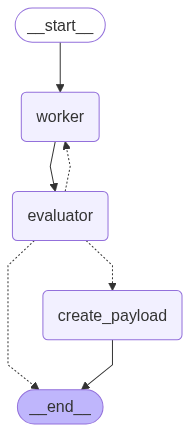

In [28]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    logger.warning(f"Failed to display graph: {str(e)}")

In [29]:
async def process_message(message: str, history: list, thread: str) -> tuple[list, str]:
    logger.info(f"Processing message: {message}")
    if not message:
        history.append({"role": "assistant", "content": "Please enter a flight query."})
        return history, thread
    
    try:
        async with asyncio.timeout(30):  # 30s timeout for LLM calls
            config = {"configurable": {"thread_id": thread}}
            # Retrieve the current state from the checkpointer
            checkpoint = checkpointer.get(config)
            logger.info(f"Checkpoint retrieved: {checkpoint}")
            
            if checkpoint and "state" in checkpoint:
                current_state = checkpoint["state"]
                logger.info(f"Retrieved checkpoint state: {current_state}")
                # Append new user message to existing messages
                current_state["messages"].append(HumanMessage(content=message))
                # Reset iteration count and user_input_needed if continuing conversation
                if current_state["user_input_needed"]:
                    current_state["iteration_count"] = 0
                    current_state["user_input_needed"] = False
            else:
                # Initialize new state for first message or if checkpoint is missing
                logger.warning("No valid checkpoint found, initializing new state")
                current_state = {
                    "messages": [HumanMessage(content=message)],
                    "success_criteria": FIXED_SUCCESS_CRITERIA,
                    "feedback_on_work": None,
                    "success_criteria_met": False,
                    "user_input_needed": False,
                    "iteration_count": 0,
                    "payload": None
                }
            
            logger.info(f"Invoking graph with state: {current_state}")
            result = await graph.ainvoke(current_state, config=config)
            logger.info(f"Graph result: {result}")
            
            user_msg = {"role": "user", "content": message}
            try:
                # Check if the graph has terminated (success, user input needed, or max iterations)
                if result["success_criteria_met"] or result["user_input_needed"] or result["iteration_count"] >= 5:
                    # Extract the worker's response or payload message
                    if result.get("payload"):
                        reply = {"role": "assistant", "content": result["messages"][-1].content}
                    else:
                        reply = {"role": "assistant", "content": result["messages"][-2].content}
                    feedback = {"role": "assistant", "content": result["messages"][-1].content}
                else:
                    reply = {"role": "assistant", "content": result["messages"][-2].content}
                    feedback = {"role": "assistant", "content": result["messages"][-1].content}
                
                history.append(user_msg)
                history.append(reply)
                history.append(feedback)
            except IndexError as e:
                logger.error(f"IndexError in accessing messages: {str(e)}")
                reply = {"role": "assistant", "content": "Error: Incomplete response from assistant"}
                feedback = {"role": "assistant", "content": "Evaluator Feedback: Incomplete response, please try again"}
                history.append(user_msg)
                history.append(reply)
                history.append(feedback)
            return history, thread
    except asyncio.TimeoutError:
        logger.error("Processing timed out")
        history.append({"role": "assistant", "content": "Processing timed out. Please try a simpler query or check your connection."})
        return history, thread
    except Exception as e:
        logger.error(f"Error in process_message: {str(e)}")
        history.append({"role": "assistant", "content": f"Error: {str(e)}"})
        return history, thread

In [30]:
async def reset() -> tuple[str, list, str]:
    logger.info("Resetting chatbot state")
    return "", [], str(uuid.uuid4())

In [31]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="blue")) as demo:
    gr.Markdown("## Travel Chatbot")
    thread = gr.State(value=str(uuid.uuid4()))
    with gr.Row():
        chatbot = gr.Chatbot(label="Travel Assistant", height=400, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Enter your flight query (e.g., 'I want to fly from NYC to LA')")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, chatbot, thread], [chatbot, thread])
    go_button.click(process_message, [message, chatbot, thread], [chatbot, thread])
    reset_button.click(reset, [], [message, chatbot, thread])

INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [ ]:
if __name__ == "__main__":
    try:
        demo.launch()
    except Exception as e:
        logger.error(f"Failed to launch Gradio app: {str(e)}")
        raise

* Running on local URL:  http://127.0.0.1:7860


INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* To create a public link, set `share=True` in `launch()`.


INFO:__main__:Processing message: hi, i want to go to mumbai from gandhinagr
INFO:__main__:Checkpoint retrieved: None
INFO:__main__:Invoking graph with state: {'messages': [HumanMessage(content='hi, i want to go to mumbai from gandhinagr', additional_kwargs={}, response_metadata={})], 'success_criteria': 'The assistant must obtain and confirm the following required flight details: departure city, arrival city, departure date, number of adults, number of children.Optional details include travel class.The final response should clearly list all obtained details in a confirmatory message and must ask if the user wants to proceed with the booking.', 'feedback_on_work': None, 'success_criteria_met': False, 'user_input_needed': False, 'iteration_count': 0, 'payload': None}
INFO:__main__:Worker node called with state: {'messages': [HumanMessage(content='hi, i want to go to mumbai from gandhinagr', additional_kwargs={}, response_metadata={}, id='372b260f-7142-486b-a63a-c7f9a580e042')], 'success